In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 6
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [4]:
data_x_seq, data_y_seq = add_data(1, 1, '1L', 'GD')
print(len(data_y_seq))
print([len(i) for i in data_y_seq])
print(sum([len(i) for i in data_y_seq]))
# print(data_y_seq)

4
[71, 134, 927, 73]
1205


In [6]:
step_data_list = []
for i in range(1,6):
    step_data_list.append([i, 1, '1L', 'GD'])
    step_data_list.append([i, 1, '2R', 'GD'])
    step_data_list.append([i, 4, '1L', 'GD'])
    step_data_list.append([i, 4, '2R', 'GD'])
    step_data_list.append([i, 8, '1L', 'GD'])
    step_data_list.append([i, 8, '2R', 'GD'])
    
print(step_data_list)

[[1, 1, '1L', 'GD'], [1, 1, '2R', 'GD'], [1, 4, '1L', 'GD'], [1, 4, '2R', 'GD'], [1, 8, '1L', 'GD'], [1, 8, '2R', 'GD'], [2, 1, '1L', 'GD'], [2, 1, '2R', 'GD'], [2, 4, '1L', 'GD'], [2, 4, '2R', 'GD'], [2, 8, '1L', 'GD'], [2, 8, '2R', 'GD'], [3, 1, '1L', 'GD'], [3, 1, '2R', 'GD'], [3, 4, '1L', 'GD'], [3, 4, '2R', 'GD'], [3, 8, '1L', 'GD'], [3, 8, '2R', 'GD'], [4, 1, '1L', 'GD'], [4, 1, '2R', 'GD'], [4, 4, '1L', 'GD'], [4, 4, '2R', 'GD'], [4, 8, '1L', 'GD'], [4, 8, '2R', 'GD'], [5, 1, '1L', 'GD'], [5, 1, '2R', 'GD'], [5, 4, '1L', 'GD'], [5, 4, '2R', 'GD'], [5, 8, '1L', 'GD'], [5, 8, '2R', 'GD']]


In [7]:
data_x, data_y = [], []
for i in step_data_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    for dx in data_x_segement:
        data_x.extend(dx)
    for dy in data_y_segement:
        data_y.extend(dy)
    
print(len(data_x))
print(len(data_y))

65796
65796


In [13]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [data_y[i] for i in order]

print(len(train_x))

65796


In [14]:
step_test_list = []   

for i in range(6,7):
    step_test_list.append([i, 1, '1L', 'GD'])
    step_test_list.append([i, 1, '2R', 'GD'])
    step_test_list.append([i, 4, '1L', 'GD'])
    step_test_list.append([i, 4, '2R', 'GD'])
    step_test_list.append([i, 8, '1L', 'GD'])
    step_test_list.append([i, 8, '2R', 'GD'])
      
print(step_test_list)

[[6, 1, '1L', 'GD'], [6, 1, '2R', 'GD'], [6, 4, '1L', 'GD'], [6, 4, '2R', 'GD'], [6, 8, '1L', 'GD'], [6, 8, '2R', 'GD']]


In [15]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

14
14
[576, 1205, 53, 576, 1205, 53, 418, 830, 418, 830, 451, 919, 451, 919]


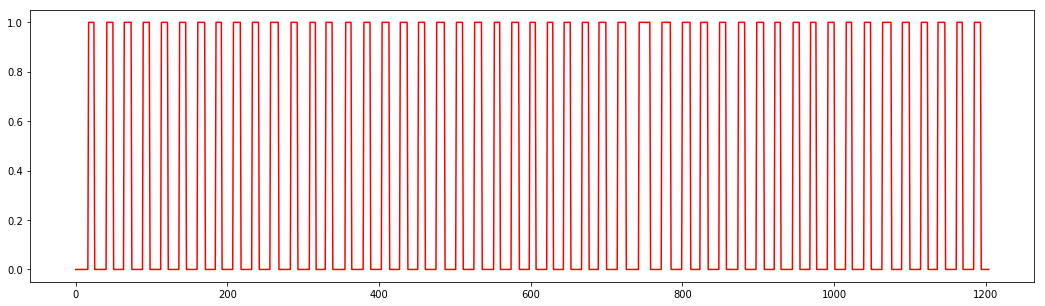

In [16]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [22]:
NUM_LAYERS=2

def LstmCell():
#     lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
#     return lstm_cell
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [18]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

65796
65796


In [19]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

66052


In [20]:
def cal_accuarcy(y, _y):
    count = 0
    for i in range(0, len(y)):
        if(y[i][0] == round(_y[i][0])):
            count += 1;
    return count*1.0/len(y)
#     print("train accuarcy : ", count/len(y))

In [24]:
training_steps = 4001

config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2.ckpt-6000")
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 1000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-error-metric-dropout2-gd.ckpt', global_step=step)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
#     test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})
    test_loss, test_logits = [], []
    for i in range(len(test_x)):
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
        test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
        test_loss.append(test_loss_part)
        test_logits.append(test_logits_part)

Initialized
Loss at step 0: 4.050087, train accuarcy : 0.003906
Loss at step 200: 0.194739, train accuarcy : 0.726562
Loss at step 400: 0.163385, train accuarcy : 0.773438
Loss at step 600: 0.150158, train accuarcy : 0.808594
Loss at step 800: 0.156910, train accuarcy : 0.777344
Loss at step 1000: 0.137748, train accuarcy : 0.820312
Loss at step 1200: 0.109813, train accuarcy : 0.886719
Loss at step 1400: 0.125936, train accuarcy : 0.824219
Loss at step 1600: 0.109720, train accuarcy : 0.863281
Loss at step 1800: 0.102731, train accuarcy : 0.875000
Loss at step 2000: 0.109104, train accuarcy : 0.855469
Loss at step 2200: 0.088314, train accuarcy : 0.882812
Loss at step 2400: 0.087843, train accuarcy : 0.917969
Loss at step 2600: 0.074651, train accuarcy : 0.914062
Loss at step 2800: 0.093541, train accuarcy : 0.878906
Loss at step 3000: 0.090878, train accuarcy : 0.890625
Loss at step 3200: 0.080985, train accuarcy : 0.902344
Loss at step 3400: 0.079091, train accuarcy : 0.910156
Loss 

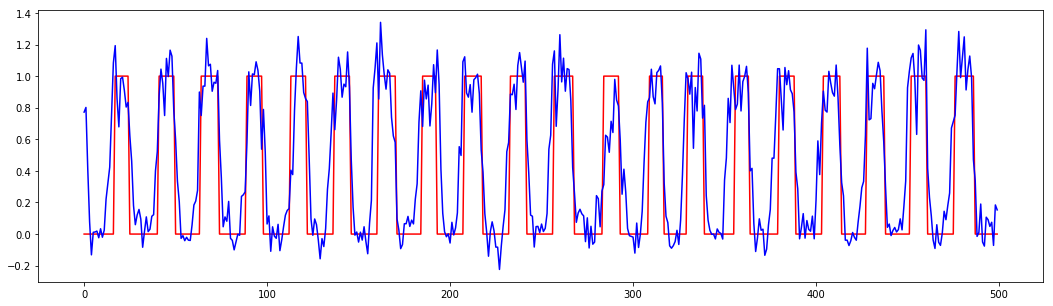

In [26]:
plt.figure(figsize=(18, 5))
start=0
end=500
plt.plot([i[0] for i in test_y[1][start:end]], 'r')
plt.plot([i[0] for i in test_logits[1][start:end]], 'b')
plt.show()

In [28]:
print("test loss : ", test_loss)
print(len(test_loss))

test loss :  [0.10008051, 0.11092666, 0.06995181, 0.10901552, 0.093801834, 0.12246722, 0.060638063, 0.077572837, 0.048847429, 0.065455921, 0.064904518, 0.050684445, 0.062602758, 0.059449852]
14


In [29]:
test_logits_bin = []
for t in test_logits:
    test_logits_part = [[round(i[0])] for i in t]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin.append(test_logits_part)

count = 0
total = 0
for i in range(0, len(test_x)):
    total += len(test_y[i])
    for j in range(0, len(test_y[i])):
        if(test_y[i][j][0] == test_logits_bin[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

8086
8904
test accuarcy :  0.9081311769991015


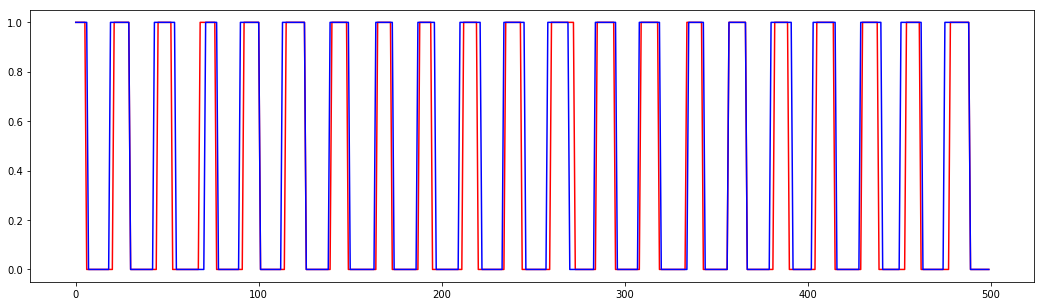

In [30]:
plt.figure(figsize=(18, 5))
start=0
end=500
plt.plot([i[0] for i in test_y[0][start:end]], 'r')
plt.plot([i[0] for i in test_logits_bin[0][start:end]], 'b')
plt.show()

In [31]:
#test_y      [[0], [0], [1]]
#test_logits 

step_time_actual, step_time_predict= [], []

for i in range(0, len(test_x)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(0, len(test_y[i])-1):
        if(abs(test_y[i][j][0]-test_y[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin[i][j][0]-test_logits_bin[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)

print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

[48, 98, 4, 48, 98, 4, 38, 74, 38, 74, 36, 72, 36, 72]
[48, 100, 4, 48, 100, 4, 38, 74, 38, 74, 36, 72, 36, 72]


In [32]:
print(step_time_actual[0])
print(step_time_predict[0])

[0, 6, 21, 30, 45, 53, 68, 77, 92, 101, 115, 126, 140, 149, 165, 173, 188, 195, 212, 220, 235, 244, 260, 273, 285, 295, 309, 319, 334, 343, 357, 367, 382, 390, 405, 415, 430, 439, 454, 462, 478, 489, 506, 514, 528, 537, 551, 560]
[7, 19, 30, 43, 55, 71, 78, 90, 101, 113, 126, 139, 150, 164, 174, 187, 197, 210, 222, 234, 246, 258, 270, 284, 296, 308, 320, 335, 344, 357, 367, 380, 392, 403, 416, 429, 441, 451, 463, 475, 489, 506, 515, 527, 539, 549, 560, 573]


In [33]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric1_overcount = 0
metric2_overcount = 0

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric2_undercount -= diff
    if(diff>0):
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric2_overcount += diff

print('------------------')
print("total undercount metric 1 : ", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1 : ", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2 : ", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2 : ", metric2_overcount*1.0/total_step_count)

------------------
total undercount metric 1 :  0.19864864864864865
total overcount metric 1 :  0.1972972972972973
total undercount metric 2 :  0.0
total overcount metric 2 :  0.005405405405405406
